## ***Import Libraries***

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')

## ***Define Paths and Prepare for Data***

In [2]:
train_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
val_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

In [3]:
class BraTSDataset(Dataset):
    def __init__(self, patient_list, data_dir, is_train=True, transform=None, slice_range=(60, 100)):
        self.data_dir = data_dir
        self.is_train = is_train
        self.transform = transform
        self.modalities = ["flair", "t1", "t1ce", "t2"]
        self.patients = [p for p in patient_list if not p.endswith(".csv")]
        self.slice_range = slice_range
        
    def load_nifti(self, path):
        nifti_img = nib.load(path)
        return np.array(nifti_img.get_fdata(), dtype=np.float32)
    
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_path = os.path.join(self.data_dir, patient_id)
        
        # Load 4 MR modalities
        images = []
        for modality in self.modalities:
            img_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
            img = self.load_nifti(img_path)
            start_slice, end_slice = self.slice_range
            img = img[:, :, start_slice:end_slice]
            if np.std(img) > 0:
                img = (img - np.mean(img)) / np.std(img)
            else:
                img = np.zeros_like(img)
            images.append(img)
        
        images = np.stack(images, axis=0)
        images = torch.tensor(images, dtype=torch.float32)
        
        if self.is_train:
            # Search for any segmentation file in the patient directory
            seg_files = [f for f in os.listdir(patient_path) if f.endswith(('_seg.nii', '_Segm.nii', '_Segmentation.nii'))]
            
            if not seg_files:
                print(f"Warning: No segmentation file found for patient {patient_id}")
                mask = np.zeros(images.shape[2:], dtype=np.uint8)  # Fallback
            else:
                seg_path = os.path.join(patient_path, seg_files[0])  # Take the first match
                mask = self.load_nifti(seg_path)
                mask = mask[:, :, self.slice_range[0]:self.slice_range[1]]
                # print(f"Loaded mask for {patient_id}: {seg_files[0]}")
            
            # Transform labels from [0, 1, 2, 4] to [0, 1, 2, 3]
            mask = mask.astype(np.uint8)
            mask[mask == 4] = 3
            mask = torch.tensor(mask, dtype=torch.long)
            
            # Debug: Print unique values in mask
            # print(f"Patient {patient_id} - Unique mask values: {mask.unique()}")
            
            if self.transform:
                images = self.transform(images)
            
            return images, mask
        else:
            if self.transform:
                images = self.transform(images)
            return images

In [4]:

def get_subset_patients(patient_list, ratio=0.2, seed=42):
    random.seed(seed)
    subset_size = int(len(patient_list) * ratio)
    return random.sample(patient_list, subset_size)

# Prepare datasets (with memory optimization)
all_train_patients = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
all_test_patients = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

# For quick testing/debugging, use smaller subset
use_subset = True  # Set to False for full training
if use_subset:
    all_train_patients = get_subset_patients(all_train_patients, ratio=0.2)
    all_test_patients = get_subset_patients(all_test_patients, ratio=0.2)

print(f"Using {len(all_train_patients)} training patients and {len(all_test_patients)} test patients")

# Split training data into train and validation
train_patients, val_patients = train_test_split(all_train_patients, test_size=0.2, random_state=42)

# Create datasets with reduced slice range to save memory
train_dataset = BraTSDataset(train_patients, train_dir, slice_range=(60, 100))
val_dataset = BraTSDataset(val_patients, train_dir, slice_range=(60, 100))
test_dataset = BraTSDataset(all_test_patients, val_dir, is_train=False, slice_range=(60, 100))

# DataLoaders with small batch_size but more workers if available
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Check sample data dimensions
sample_img, sample_mask = next(iter(train_loader))
print(f"Train set image dimension: {sample_img.shape}")  # Should be smaller now
print(f"Train set segmentation dimension: {sample_mask.shape}")

sample_img, sample_mask = next(iter(val_loader))
print("Validation set image dimension:", sample_img.shape)
print("Validation set segmentation dimension:", sample_mask.shape)

sample_img = next(iter(test_loader))
print("Test set image dimension:", sample_img.shape)

Using 73 training patients and 25 test patients
Train set image dimension: torch.Size([1, 4, 240, 240, 40])
Train set segmentation dimension: torch.Size([1, 240, 240, 40])
Validation set image dimension: torch.Size([1, 4, 240, 240, 40])
Validation set segmentation dimension: torch.Size([1, 240, 240, 40])
Test set image dimension: torch.Size([1, 4, 240, 240, 40])


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    torch.cuda.empty_cache()  # Clear GPU cache before starting
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else 
          f"Using {torch.cuda.get_device_name(0)} for training.")
else:
    print("Using CPU for training.")

Using Tesla P100-PCIE-16GB for training.


## ***Building Model Architecture, Dice Loss and Setting Hyperparameters***

In [6]:
# Improved 3D UNet with residual connections and deeper architecture
class ImprovedUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, base_filters=16):
        super(ImprovedUNet3D, self).__init__()
        
        # Encoder path with residual blocks
        self.enc1 = self._make_layer(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.enc2 = self._make_layer(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.enc3 = self._make_layer(base_filters*2, base_filters*4)
        
        # Decoder path with skip connections
        self.upconv2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = self._make_layer(base_filters*4, base_filters*2)
        
        self.upconv1 = nn.ConvTranspose3d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.dec1 = self._make_layer(base_filters*2, base_filters)
        
        # Output layer with dropout for regularization
        self.dropout = nn.Dropout3d(0.3)
        self.final_conv = nn.Conv3d(base_filters, out_channels, kernel_size=1)
        
        # Initialize weights for better convergence
        self._initialize_weights()
        
    def _make_layer(self, in_channels, out_channels):
        """Create a residual block"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),  # More stable than BatchNorm for small batches
            nn.LeakyReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm3d):
                if m.weight is not None:  # Eğer weight tanımlıysa
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:  # Eğer bias tanımlıysa
                    nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Encoder
        enc1_out = self.enc1(x)
        p1 = self.pool1(enc1_out)
        
        enc2_out = self.enc2(p1)
        p2 = self.pool2(enc2_out)
        
        # Bottom level
        enc3_out = self.enc3(p2)
        
        # Decoder with skip connections
        up2 = self.upconv2(enc3_out)
        # Ensure sizes match for skip connection
        diffY = enc2_out.size()[2] - up2.size()[2]
        diffX = enc2_out.size()[3] - up2.size()[3]
        diffZ = enc2_out.size()[4] - up2.size()[4]
        
        up2 = F.pad(up2, [
            diffZ // 2, diffZ - diffZ // 2,
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        concat2 = torch.cat([up2, enc2_out], dim=1)
        dec2_out = self.dec2(concat2)
        
        up1 = self.upconv1(dec2_out)
        # Ensure sizes match for skip connection
        diffY = enc1_out.size()[2] - up1.size()[2]
        diffX = enc1_out.size()[3] - up1.size()[3]
        diffZ = enc1_out.size()[4] - up1.size()[4]
        
        up1 = F.pad(up1, [
            diffZ // 2, diffZ - diffZ // 2,
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        concat1 = torch.cat([up1, enc1_out], dim=1)
        dec1_out = self.dec1(concat1)
        
        # Apply dropout for regularization
        x = self.dropout(dec1_out)
        
        # Final classification layer
        out = self.final_conv(x)
        
        return out

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # y_pred: model output logits [batch_size, 4, H, W, D], Float
        # y_true: mask [batch_size, H, W, D], Long
        
        y_pred = F.softmax(y_pred, dim=1)  # Convert logits to probabilities, Float
        y_true_one_hot = F.one_hot(y_true, num_classes=4).permute(0, 4, 1, 2, 3).float()  # Convert Long to one-hot Float
        
        y_pred = y_pred.view(y_pred.shape[0], 4, -1)
        y_true_one_hot = y_true_one_hot.view(y_true_one_hot.shape[0], 4, -1)
        
        intersection = (y_pred * y_true_one_hot).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (y_pred.sum(dim=2) + y_true_one_hot.sum(dim=2) + self.smooth)
        
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # inputs: model output logits [batch_size, 4, H, W, D], Float
        # targets: mask [batch_size, H, W, D], Long
        ce_loss = self.ce_loss(inputs, targets)  # Works fine with Long targets
        dice_loss = self.dice_loss(inputs, targets)
        return self.weight_ce * ce_loss + self.weight_dice * dice_loss

In [8]:
# Initialize model with improved architecture
model = ImprovedUNet3D(in_channels=4, out_channels=4, base_filters=16)
model = model.to(device)

# Use mixed precision for memory efficiency
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Use combined loss for better segmentation results
criterion = CombinedLoss(weight_dice=0.7, weight_ce=0.3)

# Cosine annealing learning rate for better convergence
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

# Updated Dice coefficient for evaluation
def dice_coefficient(y_pred, y_true, smooth=1e-6):
    # y_pred: model output logits [batch_size, 4, H, W, D], Float
    # y_true: mask [batch_size, H, W, D], Long
    y_pred = F.softmax(y_pred, dim=1)  # Convert logits to probabilities
    y_true_one_hot = F.one_hot(y_true, num_classes=4).permute(0, 4, 1, 2, 3).float()
    
    y_pred = y_pred.view(y_pred.shape[0], 4, -1)
    y_true_one_hot = y_true_one_hot.view(y_true_one_hot.shape[0], 4, -1)
    
    intersection = (y_pred * y_true_one_hot).sum(dim=2)
    dice = (2. * intersection + smooth) / (y_pred.sum(dim=2) + y_true_one_hot.sum(dim=2) + smooth)
    
    return dice.mean().item()
    


## ***Train-Validation Functions***

In [9]:
# Function to train for one epoch with memory optimization
def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    epoch_loss = 0.0
    dice_score = 0.0
    batch_count = 0
    
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        epoch_loss += loss.item()
        
        # Get predictions (for logging or other uses, but not for Dice)
        if outputs.shape[1] > 1:
            _, preds = torch.max(outputs, 1)
        else:
            preds = (torch.sigmoid(outputs) > 0.5).float()
        
        # Use raw outputs (logits) for Dice calculation
        dice = dice_coefficient(outputs, targets)  # Changed from preds to outputs
        dice_score += dice
        batch_count += 1
        
        if (i+1) % 5 == 0:
            print(f"Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}, Dice: {dice:.4f}")
        
        # Free up memory
        del inputs, targets, outputs, preds
        torch.cuda.empty_cache()
    
    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_dice = dice_score / batch_count
    
    return avg_loss, avg_dice

# Function to validate for one epoch with memory optimization
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    dice_score = 0.0
    batch_count = 0
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            epoch_loss += loss.item()
            
            # Get predictions (for logging or other uses, but not for Dice)
            if outputs.shape[1] > 1:
                _, preds = torch.max(outputs, 1)
            else:
                preds = (torch.sigmoid(outputs) > 0.5).float()
            
            dice = dice_coefficient(outputs, targets)  # Changed from preds to outputs
            dice_score += dice
            batch_count += 1
            
            del inputs, targets, outputs, preds
            torch.cuda.empty_cache()
    
    avg_loss = epoch_loss / batch_count
    avg_dice = dice_score / batch_count
    
    return avg_loss, avg_dice

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

## ***Training***

Epoch [1/100]
Batch 5/58, Loss: 1.0778, Dice: 0.0000
Batch 10/58, Loss: 0.9718, Dice: 0.0000
Batch 15/58, Loss: 1.2325, Dice: 0.0000
Batch 20/58, Loss: 0.9219, Dice: 0.0000
Batch 25/58, Loss: 0.9388, Dice: 0.0000
Batch 30/58, Loss: 0.6796, Dice: 0.0000
Batch 35/58, Loss: 0.8873, Dice: 0.0022
Batch 40/58, Loss: 0.7989, Dice: 0.0151
Batch 45/58, Loss: 0.7907, Dice: 0.0165
Batch 50/58, Loss: 0.7774, Dice: 0.0000
Batch 55/58, Loss: 0.9290, Dice: 0.0000
Epoch [1/100], Train Loss: 0.9060, Train Dice: 0.0052
Validation Loss: 0.6623, Validation Dice: 0.0000, LR: 0.000200
Epoch [2/100]
Batch 5/58, Loss: 0.5778, Dice: 0.1179
Batch 10/58, Loss: 0.7301, Dice: 0.0324
Batch 15/58, Loss: 0.6928, Dice: 0.0000
Batch 20/58, Loss: 0.6504, Dice: 0.0217
Batch 25/58, Loss: 0.5856, Dice: 0.0982
Batch 30/58, Loss: 0.6912, Dice: 0.0010
Batch 35/58, Loss: 0.6707, Dice: 0.0000
Batch 40/58, Loss: 0.6748, Dice: 0.0000
Batch 45/58, Loss: 0.6479, Dice: 0.0609
Batch 50/58, Loss: 0.4730, Dice: 0.0000
Batch 55/58, Loss

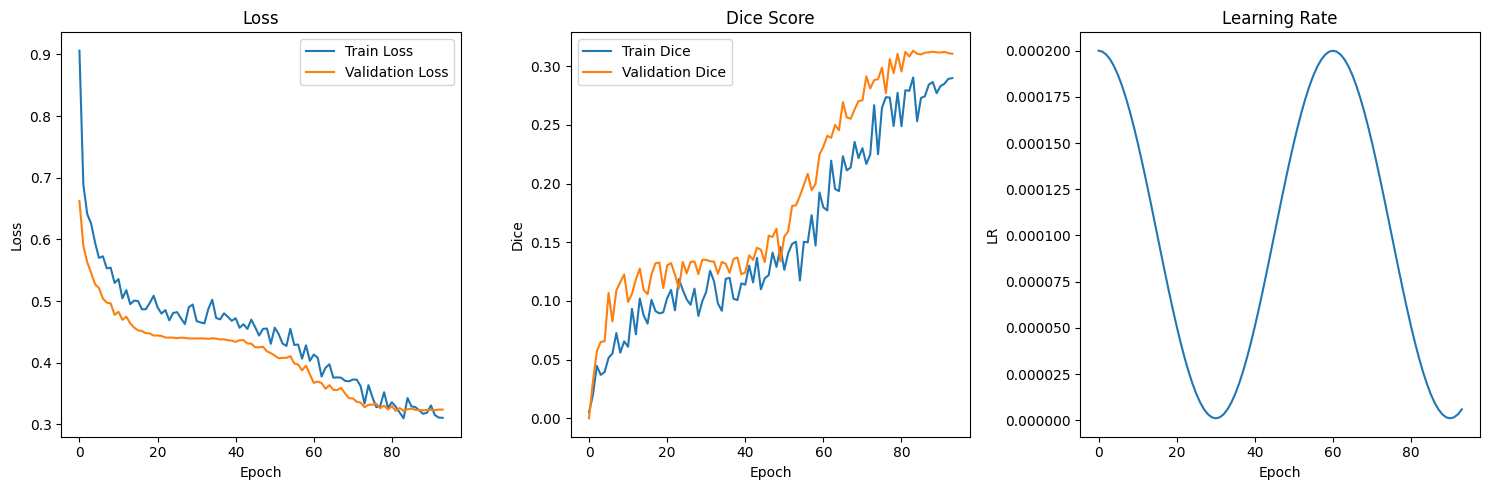

Training completed! Best validation Dice score: 0.3132


In [10]:
# Training loop with early stopping
num_epochs = 100
best_val_dice = 0.0
early_stopping = EarlyStopping(patience=10)

train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
learning_rates = []

try:
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        
        train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        train_losses.append(train_loss)
        train_dice_scores.append(train_dice)
        
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        scheduler.step()
        
        torch.cuda.empty_cache()
        
        val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, LR: {current_lr:.6f}")
        
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model, 'best_brats_model_dice.pt')
            print(f"Best model saved with Dice score: {best_val_dice:.4f}!")
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break
        
        torch.cuda.empty_cache()

except Exception as e:
    print(f"Error during training: {e}")
    torch.save(model, 'interrupted_brats_model.pt')
    print("Model saved despite interruption!")

# Plot training and validation metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_dice_scores, label='Train Dice')
plt.plot(val_dice_scores, label='Validation Dice')
plt.title('Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

print(f"Training completed! Best validation Dice score: {best_val_dice:.4f}")

## ***Evaluation and Prediction***

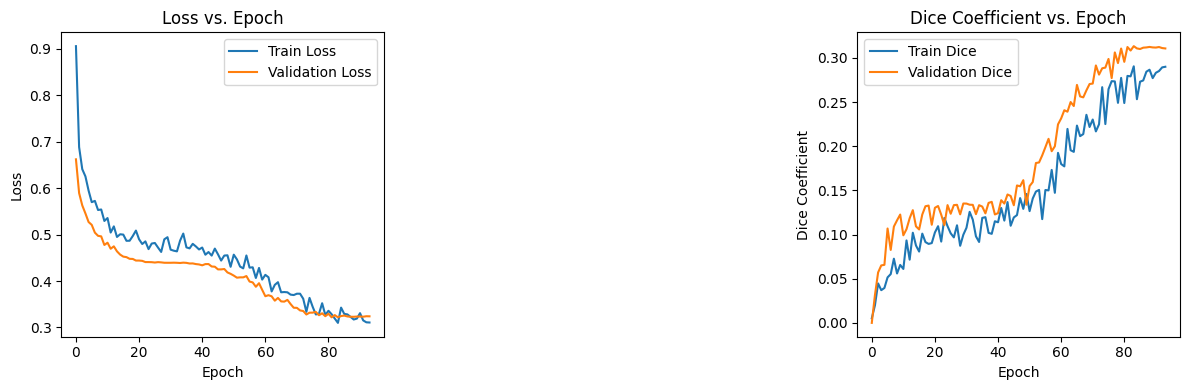

In [11]:
# Plot metrics only if training completed
if len(train_losses) > 0:
    try:        
        # Plot losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs. Epoch')
        
        # Plot Dice scores
        plt.subplot(1, 3, 3)
        plt.plot(train_dice_scores, label='Train Dice')
        plt.plot(val_dice_scores, label='Validation Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Coefficient')
        plt.legend()
        plt.title('Dice Coefficient vs. Epoch')
        
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()
    except Exception as e:
        print(f"Error creating plots: {e}")

In [12]:
# Modeli yükle
model_path = "/kaggle/working/best_brats_model_dice.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli oluştur ve ağırlıkları yükle
model = torch.load(model_path, map_location=device)
model = model.to(device)
model.eval()  # Modeli inference moduna al

ImprovedUNet3D(
  (enc1): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, trac

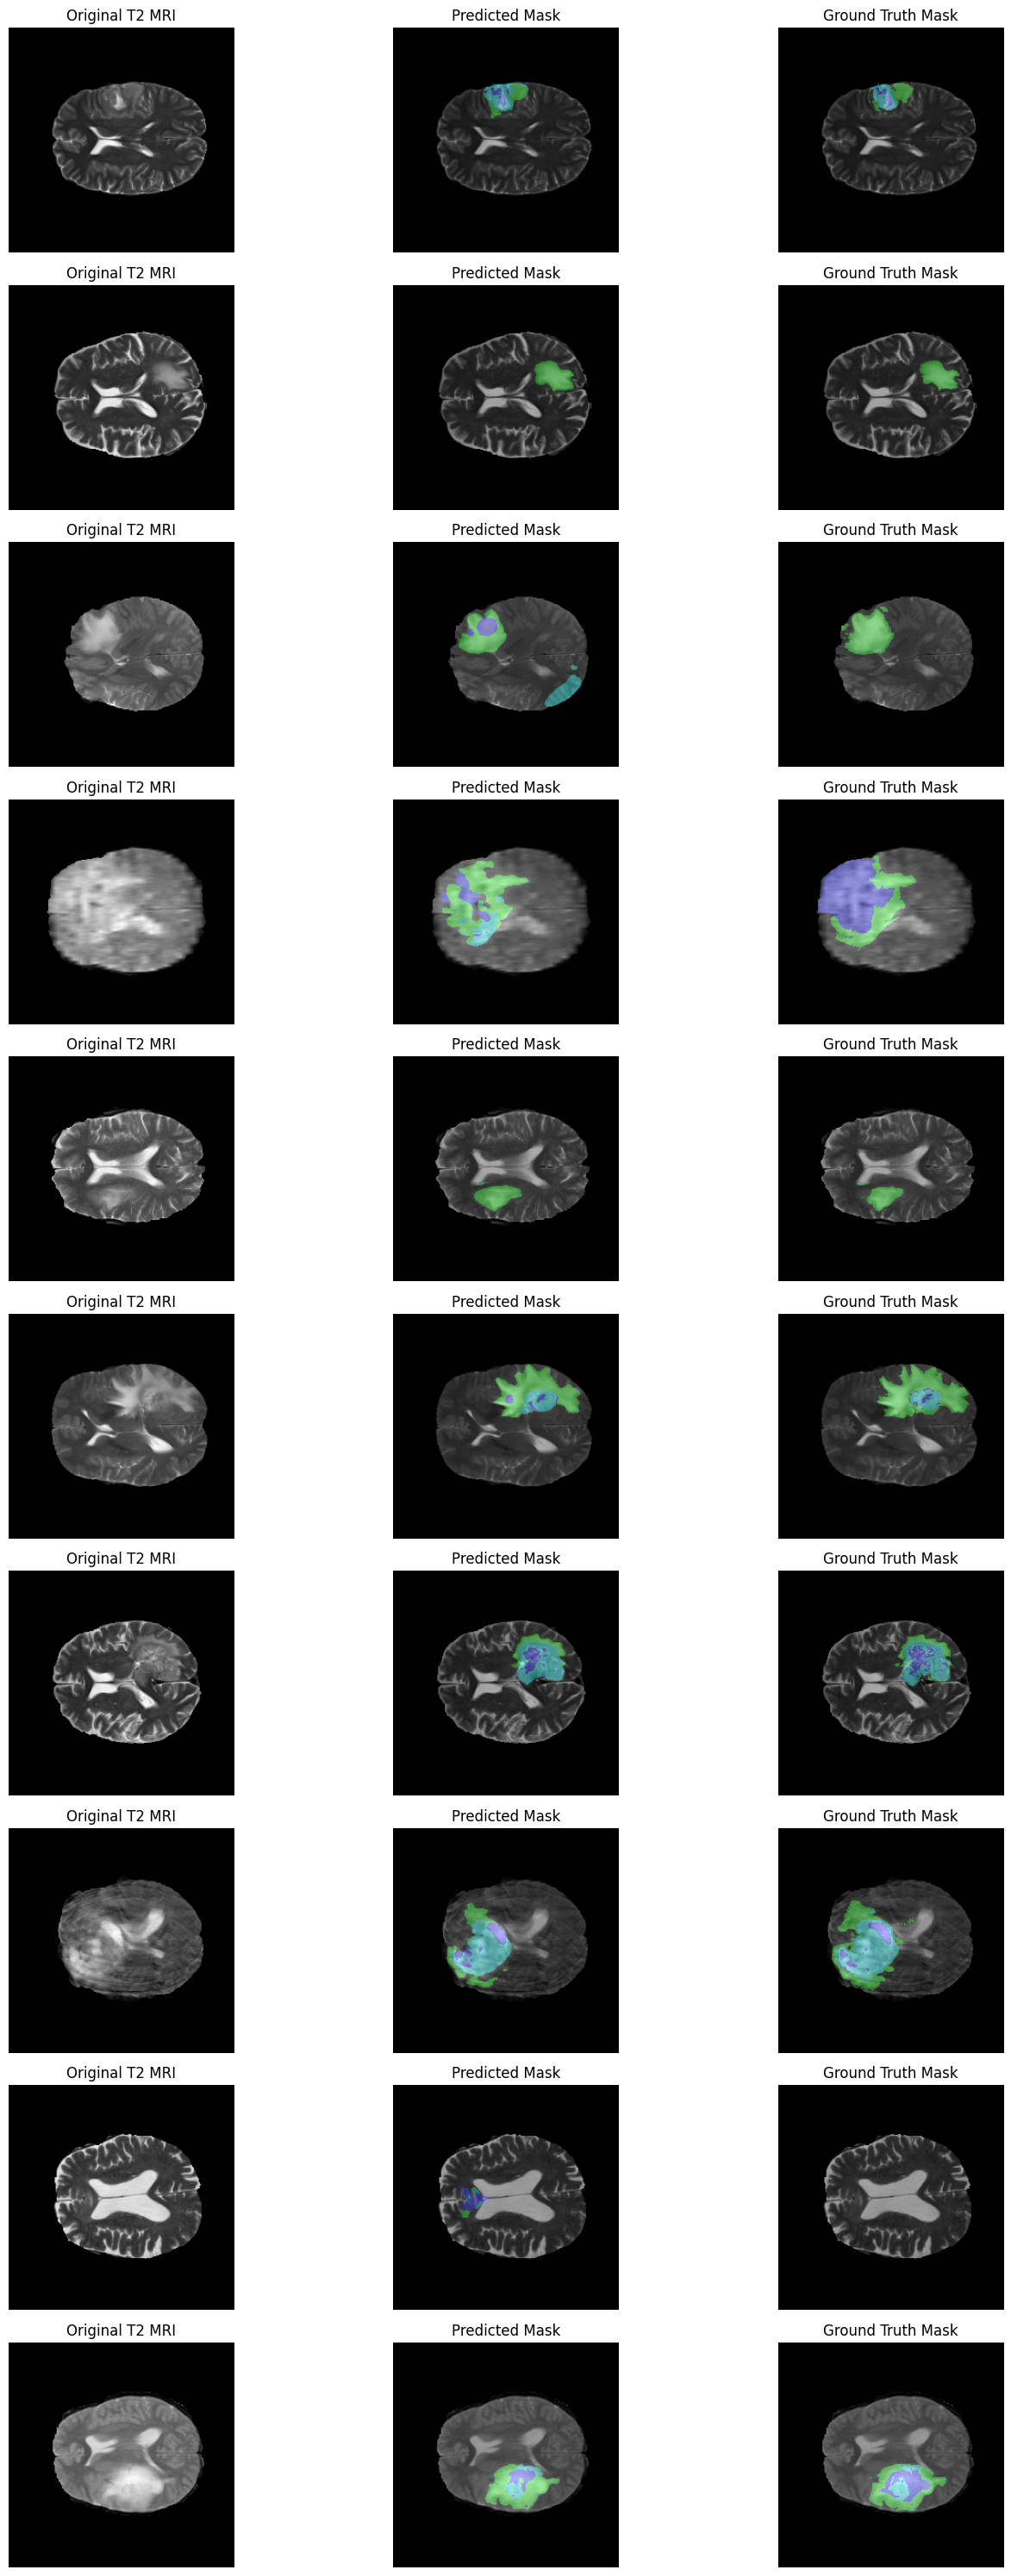

In [15]:


# Assuming val_loader returns (images, masks) with ground truth
val_iter = iter(val_loader)  # Use val_loader instead of test_loader
num_images = 10 # Show 5 examples (you can change this)
fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 3))  # 3 columns: Original, Predicted, Ground Truth

for i in range(num_images):
    # Get image and ground truth mask from val_loader
    test_image, true_mask = next(val_iter)  # test_image: (1, 4, H, W, D), true_mask: (1, H, W, D)
    test_image = test_image.to(device)
    true_mask = true_mask.numpy()  # Ground truth mask as numpy

    # Prediction with model
    with torch.no_grad():
        output = model(test_image)  # (1, 4, H, W, D) for 4 classes
        prediction = torch.argmax(output, dim=1).cpu().numpy()  # (1, H, W, D) with values [0, 1, 2, 3]

    # Transform to numpy
    test_image_np = test_image.cpu().numpy()

    # Select middle slice (e.g., D/2 within slice_range of 60-100)
    slice_idx = test_image_np.shape[4] // 2  # Depth axis D (e.g., 40 slices -> 20th slice)
    t2_slice = test_image_np[0, 3, :, :, slice_idx]  # T2 modality (channel 3)
    pred_mask = prediction[0, :, :, slice_idx]  # Predicted mask
    true_mask_slice = true_mask[0, :, :, slice_idx]  # Ground truth mask

    # Normalize and convert to 8-bit (for visualization)
    t2_slice = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    t2_colored = cv2.cvtColor(t2_slice, cv2.COLOR_GRAY2BGR)

    # Color the predicted mask for 4 classes
    pred_mask_colored = np.zeros_like(t2_colored)
    pred_mask_colored[pred_mask == 1] = [0, 0, 255]  # Red for necrotic core (class 1)
    pred_mask_colored[pred_mask == 2] = [0, 255, 0]  # Green for edema (class 2)
    pred_mask_colored[pred_mask == 3] = [0, 255, 255]  # Yellow for enhancing tumor (class 3)
    # Class 0 (background) stays transparent
    pred_blended = cv2.addWeighted(t2_colored, 0.7, pred_mask_colored, 0.3, 0)

    # Color the ground truth mask for 4 classes
    true_mask_colored = np.zeros_like(t2_colored)
    true_mask_colored[true_mask_slice == 1] = [0, 0, 255]  # Red for necrotic core (class 1)
    true_mask_colored[true_mask_slice == 2] = [0, 255, 0]  # Green for edema (class 2)
    true_mask_colored[true_mask_slice == 3] = [0, 255, 255]  # Yellow for enhancing tumor (class 3)
    # Class 0 (background) stays transparent
    true_blended = cv2.addWeighted(t2_colored, 0.7, true_mask_colored, 0.3, 0)

    # Draw images
    axes[i, 0].imshow(t2_colored)
    axes[i, 0].set_title("Original T2 MRI")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(pred_blended)
    axes[i, 1].set_title("Predicted Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(true_blended)
    axes[i, 2].set_title("Ground Truth Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## ***Conclusion***

In this study, a deep learning pipeline was created using the 3D U-Net model for brain tumor segmentation. The study includes the following steps:

### ***1. Data Preparation***
MRI images containing FLAIR, T1, T1CE and T2 modalities from the BraTS (Brain Tumor Segmentation) dataset were used.
The BraTSDataset class was created and the PyTorch dataset and data loaders (DataLoader) were configured.
For memory optimization, only the 60-100th slice range where tumors are most frequently seen was used.
The images were normalized to ensure more efficient learning of the model.

### ***2. Model Training***
The 3D U-Net model was defined and trained with GPU acceleration.
The segmentation performance of the model was optimized using Dice Loss.
The best model was recorded as "best_brats_model.pt" according to the validation Dice Score.

### ***3. Testing and Evaluation***
The trained model was evaluated on the test dataset.
Predictions were made on 10 different test images and segmentation masks were generated.
The predicted segmentation masks were visualized by overlaying the original MRI images with OpenCV.

### ***4. Results and Future Work***
The model made successful predictions on tumor segmentation.
When evaluated on the images, it was seen that the tumor areas were clearly separated.

In the future, data augmentation, larger data sets or transfer learning methods can be used to increase the accuracy of the model.
This study demonstrates the effectiveness of deep learning models for MRI-based brain tumor segmentation. The model can be used as a system that provides automatic tumor detection and segmentation that can assist doctors 🚀